# Quick start skforecast

This code is a quick example of how to create, validate and optimize a recursive multi-step forecaster, `ForecasterAutoreg`, using **skforecast**. For more detailed documentation, visit [User Guides](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/input-data.html).

## Libraries

In [1]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster

## Data

Train dates : 1991-07-01 00:00:00 --- 2005-06-01 00:00:00  (n=168)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


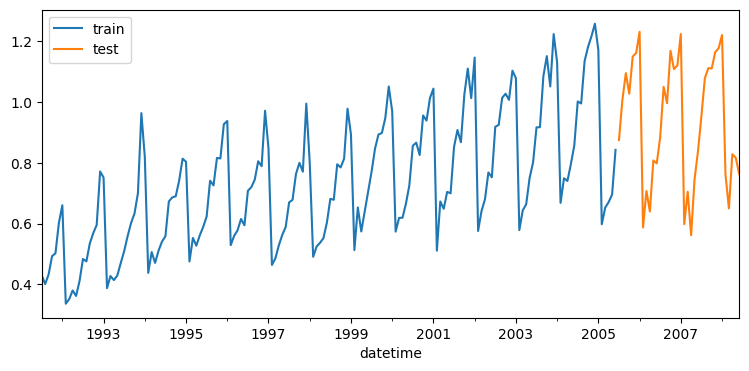

In [2]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Train-test dates
# ==============================================================================
end_train = '2005-06-01 23:59:00'

print(f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
ax.legend();

## Train forecaster

For more detailed documentation, visit: [User guide ForecasterAutoreg](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/autoregresive-forecaster.html).

In [3]:
# Create and fit Recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 15
             )

forecaster.fit(y=data.loc[:end_train])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-09-24 09:11:42 
Last fit date: 2022-09-24 09:11:42 
Skforecast version: 0.5.0 
Python version: 3.9.13 

## Prediction

This method predicts $n$ steps in the future.

In [4]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
predictions.head(3)

2005-07-01    0.921840
2005-08-01    0.954921
2005-09-01    1.101716
Freq: MS, Name: pred, dtype: float64

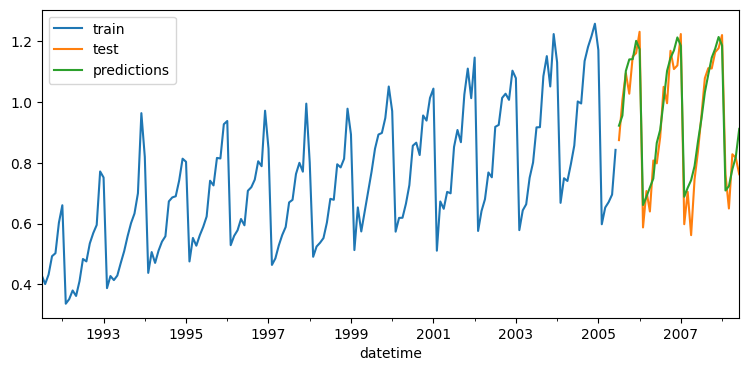

In [5]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [6]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data.loc[end_train:],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.00429855684785846


## Backtesting: forecaster validation

Backtesting is a term used in modeling to refer to testing a predictive model on historical data. Backtesting involves moving backward in time, step-by-step, in as many stages as is necessary. Therefore, it is a special type of cross-validation applied to previous period(s). For more detailed documentation, visit: [User guide Backtesting forecaster](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html).

In [7]:
# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data,
                                   initial_train_size = len(data.loc[:end_train]),
                                   fixed_train_size   = False,
                                   steps              = 10,
                                   metric             = 'mean_squared_error',
                                   refit              = True,
                                   verbose            = True
                               )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 168
Number of observations used for backtesting: 36
    Number of folds: 4
    Number of steps per fold: 10
    Last fold only includes 6 observations.

Data partition in fold: 0
    Training:   1991-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=168)
    Validation: 2005-07-01 00:00:00 -- 2006-04-01 00:00:00  (n=10)
Data partition in fold: 1
    Training:   1991-07-01 00:00:00 -- 2006-04-01 00:00:00  (n=178)
    Validation: 2006-05-01 00:00:00 -- 2007-02-01 00:00:00  (n=10)
Data partition in fold: 2
    Training:   1991-07-01 00:00:00 -- 2007-02-01 00:00:00  (n=188)
    Validation: 2007-03-01 00:00:00 -- 2007-12-01 00:00:00  (n=10)
Data partition in fold: 3
    Training:   1991-07-01 00:00:00 -- 2007-12-01 00:00:00  (n=198)
    Validation: 2008-01-01 00:00:00 -- 2008-06-01 00:00:00  (n=6)

Backtest error: 0.004810878299401304


## Grid search: forecaster optimization

Skforecast library combines grid search strategy with backtesting to identify the combination of lags and hyperparameters that achieve the best prediction performance. For more detailed documentation, visit: [Hyperparameter tuning and lags selection](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/hyperparameter-tuning-and-lags-selection.html).

In [8]:
# Grid search hyperparameter and lags
# ==============================================================================

# Regressor hyperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10, 15]}

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data,
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 10,
                   refit              = True,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:05<00:00,  1.93s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.015161925563451037



In [9]:
# Grid results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.015162,10,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 100}",0.015559,15,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 50}",0.016284,15,50
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.018412,10,50
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.018674,5,50
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.018912,5,100
14,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.037743,10,50
17,"[1, 2, 3, 20]","{'max_depth': 15, 'n_estimators': 100}",0.043362,15,100
13,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.045687,5,100
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.047272,10,50


In [10]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>